In [1]:
import numpy as np
from bluesky import preprocessors as bpp
from bluesky import plan_stubs as bps

from bluesky.utils import Msg

class Centroid:
    def __init__(self) -> None:
        self.reset()

    def reset(self):
        self._xs = list()
        self._ys = list()

    def append(self,x,y)->None:
        self._xs.append(x)
        self._ys.append(y)

    @property
    def peak_position(self):
        #pdb.set_trace()
        nx = np.array(self._xs)
        ny = np.array(self._ys)
        nyp = ny - ny.min()
        nxy = nx*nyp
        pos = nxy.sum()/nyp.sum()
        return pos
    
    @property
    def count(self):
        return len(self._xs)

def tune_centroid(
        detectors, signal, motor,
        start, stop, min_step,
        num=10,
        step_factor=3.0,
        snake=False,
        *, md=None):
    r"""
    plan: tune a motor to the modified centroid of signal(motor)

    Initially, traverse the range from start to stop with
    the number of points specified.  Repeat with progressively
    smaller step size until the minimum step size is reached.
    Rescans will be centered on the signal centroid
    (for $I(x)$, centroid$= \sum{I}/\sum{x*I}$)
    with original scan range reduced by ``step_factor``.

    Set ``snake=True`` if your positions are reproducible
    moving from either direction.  This will not necessarily
    decrease the number of traversals required to reach convergence.
    Snake motion reduces the total time spent on motion
    to reset the positioner.  For some positioners, such as
    those with hysteresis, snake scanning may not be appropriate.
    For such positioners, always approach the positions from the
    same direction.

    Note:  Ideally the signal has only one peak in the range to
    be scanned.  It is assumed the signal is not polymodal
    between ``start`` and ``stop``.

    Parameters
    ----------
    detectors : Signal
        list of 'readable' objects
    signal : string
        detector field whose output is to maximize
    motor : object
        any 'settable' object (motor, temp controller, etc.)
    start : float
        start of range
    stop : float
        end of range, note: start < stop
    min_step : float
        smallest step size to use.
    num : int, optional
        number of points with each traversal, default = 10
    step_factor : float, optional
        used in calculating new range after each pass

        note: step_factor > 1.0, default = 3
    snake : bool, optional
        if False (default), always scan from start to stop
    md : dict, optional
        metadata

    Examples
    --------
    Find the center of a peak using synthetic hardware.

    >>> from ophyd.sim import SynAxis, SynGauss
    >>> motor = SynAxis(name='motor')
    >>> det = SynGauss(name='det', motor, 'motor',
    ...                center=-1.3, Imax=1e5, sigma=0.05)
    >>> RE(tune_centroid([det], "det", motor, -1.5, -0.5, 0.01, 10))
    """
    if min_step <= 0:
        raise ValueError("min_step must be positive")
    if step_factor <= 1.0:
        raise ValueError("step_factor must be greater than 1.0")
    try:
        motor_name, = motor.hints['fields']
    except (AttributeError, ValueError):
        motor_name = motor.name
    _md = {'detectors': [det.name for det in detectors],
           'motors': [motor.name],
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motor': repr(motor),
                         'start': start,
                         'stop': stop,
                         'num': num,
                         'min_step': min_step, },
           'plan_name': 'centroid',
           'hints': {},
           }
    _md.update(md or {})
    try:
        dimensions = [(motor.hints['fields'], 'primary')]
    except (AttributeError, KeyError):
        pass
    else:
        _md['hints'].setdefault('dimensions', dimensions)

    low_limit = min(start, stop)
    high_limit = max(start, stop)

    @bpp.stage_decorator(list(detectors) + [motor])
    @bpp.run_decorator(md=_md)
    def _tune_core(start, stop, num, signal):
        next_pos = start
        step = (stop - start) / (num - 1)
        peak_position = None
        cur_I = None
        cen = Centroid()

        while abs(step) >= min_step and low_limit <= next_pos <= high_limit:
            yield Msg('checkpoint')
            yield from bps.mv(motor, next_pos)
            ret = (yield from bps.trigger_and_read(detectors + [motor]))
            cur_I = ret[signal]['value']
            position = ret[motor_name]['value']
            cen.append(position,cur_I)

            next_pos += step
            in_range = min(start, stop) <= next_pos <= max(start, stop)

            if not in_range:
                if cen.count == 0:
                    return
                peak_position = cen.peak_position  # centroid
                cen.reset()
                new_scan_range = (stop - start) / step_factor
                start = np.clip(peak_position - new_scan_range/2,
                                low_limit, high_limit)
                stop = np.clip(peak_position + new_scan_range/2,
                               low_limit, high_limit)
                if snake:
                    start, stop = stop, start
                step = (stop - start) / (num - 1)
                next_pos = start
                print("Peak position = {}".format(peak_position))
                # print("start = {}".format(start))
                # print("stop = {}".format(stop))

        # finally, move to peak position
        if peak_position is not None:
            # improvement: report final peak_position
            print("Final position = {}".format(peak_position))
            yield from bps.mv(motor, peak_position)

    return (yield from _tune_core(start, stop, num, signal))



Peak position = -1.1388933793497267
Peak position = -1.290450213848047
Peak position = -1.2998124823842
Peak position = -1.300041736870372
Final position = -1.300041736870372


('c659298f-5395-4f39-a945-31cfeea068a2',)

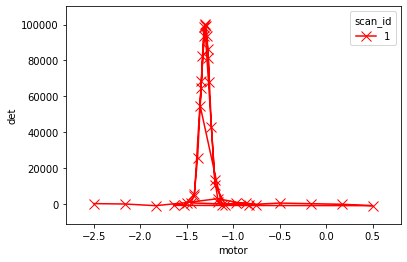

In [30]:
from ophyd.sim import SynAxis, SynGauss
motor = SynAxis(name='motor')
det = SynGauss(name='det', motor=motor, motor_field='motor', center=-1.3, Imax=1e5, sigma=0.05, noise="uniform",noise_multiplier=1e3)


from bluesky import RunEngine

RE=RunEngine({})
#Set up plotting
from bluesky.callbacks.best_effort import BestEffortCallback
from event_model import RunRouter

from bluesky.callbacks.mpl_plotting import LivePlot

num = 10                    #The number of points used in each pass
scale_factor = 3            #How much the range of each pass is scaled by.
required_precision = 0.01  #Required precision of the motor
low_range = -2.5
high_range = 0.5

RE(tune_centroid([det], "det", motor, low_range, high_range, required_precision, num,scale_factor),LivePlot('det', 'motor',marker='x', markersize=10, color='red'))

In [31]:
from bessyii_devices.keithley import Keithley6514
kth09    = Keithley6514('EMILEL:' + 'Keithley09:',  name='kth09',read_attrs=['readback'])



In [32]:
from bluesky.plans import count

RE(count([kth09]))

Run aborted
Traceback (most recent call last):
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/ophyd/signal.py", line 1116, in _get_with_timeout
    self.wait_for_connection(timeout=connection_timeout)
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/ophyd/signal.py", line 1495, in wait_for_connection
    self._ensure_connected(self._read_pv, self._write_pv, timeout=timeout)
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/ophyd/signal.py", line 1047, in _ensure_connected
    raise TimeoutError(f"{pv.pvname} could not connect within "
TimeoutError: EMILEL:Keithley09:rbkIntegrTimeSec could not connect within 1.0-second timeout.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)


ConnectionTimeoutError: Failed to connect to EMILEL:Keithley09:rbkIntegrTimeSec within 1.00 sec